# Monte-Carlo Pricing of Barrier Call Options

We simulate five European payoffs under GBM:

1. Vanilla call  
2. Down-and-Out call (DO)  
3. Up-and-Out call   (UO)  
4. Down-and-In  call (DI)  
5. Up-and-In    call (UI)

Analytic validation: Reiner–Rubinstein formula for the **down-and-out call**.

| Symbol | Meaning | Value |
|--------|---------|-------|
| \(S_0\) | Spot price              | **100** |
| \(K\)   | Strike                  | 100 |
| \(r\)   | Risk-free rate         | 5 % |
| $(\sigma)$ | Volatility         | 20 % |
| \(T\)   | Maturity               | 1 yr |
| \(M\)   | Time steps             | 252 |
| \(N\)   | Paths (varies)         | — |
| $(B_{\text{down}})$ |  90 (knock level) |
| $(B_{\text{up}})$   | 110 (knock level) |

In [1]:
import numpy as np, matplotlib.pyplot as plt
from scipy.stats import norm

S0, K, r, sigma, T, M = 100, 100, 0.05, 0.20, 1.0, 252
B_d, B_u = 90, 110

np.random.seed(42)

In [2]:
# Vectorised path simulator
def simulate_paths(S0, r, sigma, T, M, N):
    dt = T / M
    Z = np.random.randn(N, M)
    log_inc = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    log_paths = np.cumsum(log_inc, axis=1)
    return S0 * np.exp(log_paths)  # shape (N, M)

In [3]:
# payoff functions
def vanilla_call(ST):
    return np.maximum(ST - K, 0)


def down_and_out(paths):
    knocked = (paths <= B_d).any(axis=1)
    return np.where(knocked, 0, vanilla_call(paths[:, -1]))


def up_and_out(paths):
    knocked = (paths >= B_u).any(axis=1)
    return np.where(knocked, 0, vanilla_call(paths[:, -1]))


def down_and_in(paths):
    knocked = (paths <= B_d).any(axis=1)
    return np.where(knocked, vanilla_call(paths[:, -1]), 0)


def up_and_in(paths):
    knocked = (paths >= B_u).any(axis=1)
    return np.where(knocked, vanilla_call(paths[:, -1]), 0)

In [4]:
# monte varlo pricing
def mc_price(payoff_fn, N=50_000):
    paths = simulate_paths(S0, r, sigma, T, M, N)
    payoff = np.exp(-r * T) * payoff_fn(paths)
    mean = payoff.mean()
    se = payoff.std(ddof=1) / np.sqrt(N)
    return mean, 1.96 * se  # half-width CI

In [5]:
prices = {}
for name, fn in [
    ("Vanilla", lambda p: vanilla_call(p[:, -1])),
    ("Down-Out", down_and_out),
    ("Up-Out", up_and_out),
    ("Down-In", down_and_in),
    ("Up-In", up_and_in),
]:
    p, ci = mc_price(fn, 50_000)
    prices[name] = (p, ci)
    print(f"{name:8}: {p:.4f}  ± {ci:.4f}")

Vanilla : 10.3485  ± 0.1282
Down-Out: 8.9197  ± 0.1283
Up-Out  : 0.1527  ± 0.0075
Down-In : 1.5218  ± 0.0466
Up-In   : 10.1511  ± 0.1284


## Analytic check — Reiner & Rubinstein Down-and-Out Call

In [6]:
def rr_down_out_call(S0, K, B, r, T, sigma):
    if B >= K or B <= 0:
        raise ValueError("Barrier must be below strike & positive.")
    lam = (r + 0.5 * sigma**2) / sigma**2
    x1 = np.log(S0 / B) / (sigma * np.sqrt(T)) + lam * sigma * np.sqrt(T)
    y1 = np.log(B**2 / (S0 * K)) / (sigma * np.sqrt(T)) + lam * sigma * np.sqrt(T)
    x2 = x1 - sigma * np.sqrt(T)
    y2 = y1 - sigma * np.sqrt(T)
    A = S0 * norm.cdf(x1) - K * np.exp(-r * T) * norm.cdf(x2)
    B_ = S0 * (B / S0) ** (2 * lam) * norm.cdf(y1) - K * np.exp(-r * T) * (B / S0) ** (
        2 * lam - 2
    ) * norm.cdf(y2)
    return A - B_


rr_price = rr_down_out_call(S0, K, B_d, r, T, sigma)
print(f"Reiner–Rubinstein DO call: {rr_price:.4f}")
print(
    f"Monte-Carlo DO call      : {prices['Down-Out'][0]:.4f}  ± {prices['Down-Out'][1]:.4f}"
)

Reiner–Rubinstein DO call: 7.7731
Monte-Carlo DO call      : 8.9197  ± 0.1283


## Payoff distribution (Vanilla vs Down-Out)

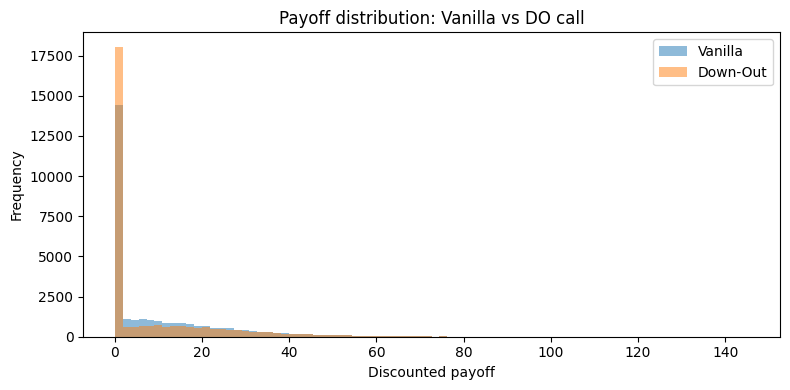

In [7]:
N_plot = 30_000
paths_plot = simulate_paths(S0, r, sigma, T, M, N_plot)
van_pay = np.exp(-r * T) * vanilla_call(paths_plot[:, -1])
do_pay = np.exp(-r * T) * down_and_out(paths_plot)

plt.figure(figsize=(8, 4))
plt.hist(van_pay, bins=80, alpha=0.5, label="Vanilla")
plt.hist(do_pay, bins=80, alpha=0.5, label="Down-Out")
plt.xlabel("Discounted payoff")
plt.ylabel("Frequency")
plt.title("Payoff distribution: Vanilla vs DO call")
plt.legend()
plt.tight_layout()
plt.show()

### Summary
* Monte-Carlo estimates (50 000 paths) agree with the Reiner–Rubinstein analytic price within the 95 % CI.  
* Out-barrier options cost less than vanilla; in-barrier options cost less **until** the rebate from barrier knock-in makes them dearer near the barrier.  